## Importación de librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## Carga de archivos

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/Bootcamp-IA-P4/flight-feel-analyzer/refs/heads/dev/data/airline_passenger_satisfaction.csv")

## Exploración Inicial

In [6]:
df.head(10)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [7]:
print('La forma del dataset es', df.shape)
print('Rows duplicadas en train dataset :', df.duplicated().sum() )

La forma del dataset es (103904, 25)
Rows duplicadas en train dataset : 0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [6]:
from ydata_profiling import ProfileReport
from IPython.display import HTML # import the HTML object

ModuleNotFoundError: No module named 'pkg_resources'

In [19]:
profile_change = ProfileReport(df,title="Airlines Satisfaction. Profiling Report", explorative=True,)
profile_change.to_file("output_change.html")
HTML(filename='output_change.html')

NameError: name 'ProfileReport' is not defined

In [7]:
df.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


## Limpieza

In [8]:
df = df.drop(df.iloc[:,[0, 1]], axis = 1)

Aqui borramos las primeras 2 columnas (unnamed y id) porque no aportan valor

### Missing values

In [9]:
correlation_arrival = df.corr(numeric_only=True)['Arrival Delay in Minutes'].sort_values(ascending=False)
print(correlation_arrival)

Arrival Delay in Minutes             1.000000
Departure Delay in Minutes           0.965481
Leg room service                     0.011843
Gate location                        0.005143
Departure/Arrival time convenient   -0.000864
Flight Distance                     -0.002426
Ease of Online booking              -0.007984
Baggage handling                    -0.008542
Age                                 -0.012147
Cleanliness                         -0.015774
Inflight wifi service               -0.019095
Checkin service                     -0.020369
Online boarding                     -0.021949
Seat comfort                        -0.029900
Inflight entertainment              -0.030703
Food and drink                      -0.032524
On-board service                    -0.035227
Inflight service                    -0.059196
Name: Arrival Delay in Minutes, dtype: float64


Vemos la relación que tiene la variable con missing data (Arrival Delay in Minutes) con otras

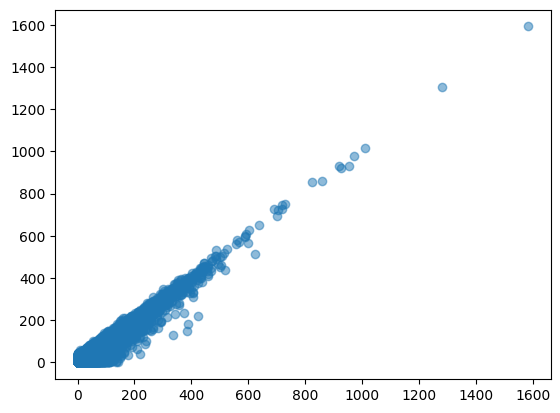

In [10]:
plt.scatter(df['Arrival Delay in Minutes'], df['Departure Delay in Minutes'], alpha = 0.5)
pass

In [11]:
from sklearn.linear_model import LinearRegression

# Separar los datos donde no hay NaN (para entrenar el modelo)
train_data = df.dropna(subset=['Arrival Delay in Minutes'])
X_train = train_data[['Departure Delay in Minutes']]
y_train = train_data['Arrival Delay in Minutes']

# Entrenar modelo lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores faltantes
missing_mask = df['Arrival Delay in Minutes'].isnull()
X_missing = df.loc[missing_mask, ['Departure Delay in Minutes']]
df.loc[missing_mask, 'Arrival Delay in Minutes'] = model.predict(X_missing)


Imputamos los datos faltantes con una regresión lineal tomando como la variable predictora el Departure Delay in Minutes que es la que tiene una correlación de casi 0,97.

In [12]:
df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

### Outliers

In [13]:
def calculate_outliers_percentage(df):
    # Filtrar solo columnas numéricas
    df_numeric = df.select_dtypes(include='number')

    # Calcular los cuartiles y el IQR
    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    IQR = Q3 - Q1

    # Límites para detectar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los outliers por columna
    num_outliers = ((df_numeric < lower_bound) | (df_numeric > upper_bound)).sum()

    # Calcular el porcentaje de outliers
    pct_outliers = round(num_outliers / len(df) * 100, 4)

    return pct_outliers

In [14]:
outliers = pd.DataFrame(calculate_outliers_percentage(df), columns=['% Outliers'])
outliers.index.name = 'Column Name'
outliers.reset_index(inplace=True)
outliers

,Column Name,% Outliers
0,Age,0.0000
1,Flight Distance,2.2049
2,Inflight wifi service,0.0000
3,Departure/Arrival time convenient,0.0000
4,Ease of Online booking,0.0000
5,Gate location,0.0000
6,Food and drink,0.0000
7,Online boarding,0.0000
8,Seat comfort,0.0000
9,Inflight entertainment,0.0000


Se pueden ver un gran número de valores atípicos en los retrasos y servicio check-in, y algunos en la distancia de vuelo. No obstante, en estos casos no podemos considerar que estos valores no sean válidos, ya que es factible que haya habido puntualmente algún retraso muy exagerado o una situación de colapso en check-in.

### Encoding de variables categóricas

Codificamos las variables categóricas que tienen unicamente dos valores como binarios.

In [15]:
df['Gender'] = np.where(df['Gender'] == 'Male', 1, 0).astype('int16')
df['Customer Type'] = np.where(df['Customer Type'] == 'Loyal Customer', 1, 0).astype('int16')
df['Type of Travel'] = np.where(df['Type of Travel'] == 'Business Travel', 1, 0).astype('int16')

Encoding de la variable dependiente

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_encoded = le.fit_transform(df['satisfaction'])
df['satisfaction'] = col_encoded
df['satisfaction'].unique()

array([0, 1])

Label Encoder guarda una relación entre el número y la etiqueta original y permite revertir la codificación (inverse_transform) para interpretar resultados. Es buena práctca para la codificación de una variable dependiente categórica.

In [17]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['Eco', 'Eco Plus', 'Business']])
df['Class'] = encoder.fit_transform(df[['Class']]).astype('int8')

Usamos un Ordinal Encoding para preservar la jerarquía implícita, ya que Business > Eco Plus > Eco en términos de calidad/precio/servicio. Es una variable con orden, si usasemos One-Hot Encoding se perdería la jerarquía y los modelos no podrán captar que Business > Eco Plus > Eco, porque todas las clases se tratan como independientes

## Correlaciones después de la limpieza

Text(0.5, 1.0, 'Data correlations after Preprocessing')

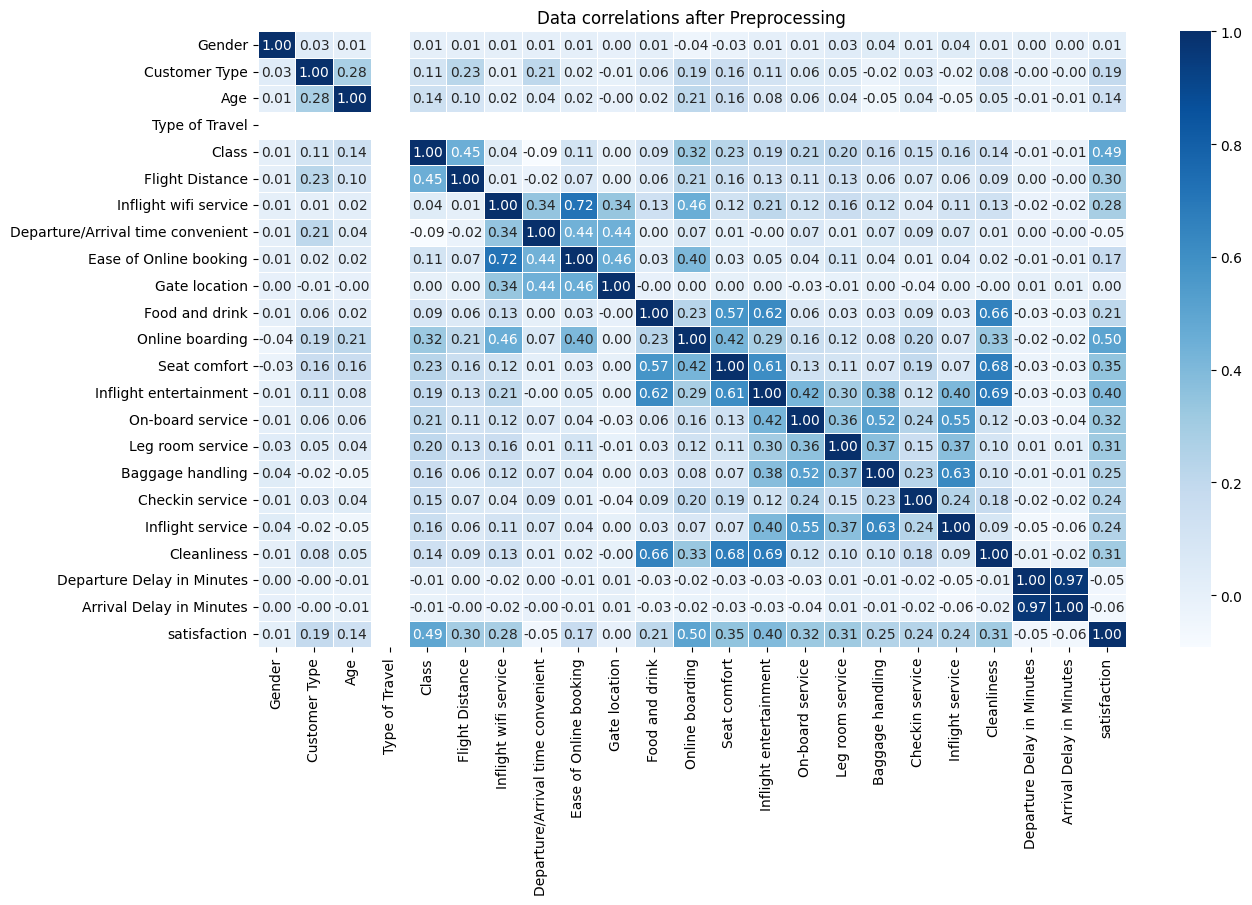

In [18]:
correlation=df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(correlation,annot=True,fmt='.2f',annot_kws={'size': 10},linewidths=0.5,cmap='Blues')
plt.title("Data correlations after Preprocessing")

## Data Splitting

In [19]:
X = df.drop(["satisfaction"], axis = 1)
y = df["satisfaction"]

Extraemos las features y la variable dependiente (la y, satifaction)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

Dividimos el dataset en training y test, con proporción de 80% del training y 20% del test y stratificamos para mantener el balance de clases en ambos grupos.

In [21]:
from sklearn.model_selection import StratifiedKFold

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Preparamos para implementar la validación cruzada:
- Partimos el dataset en 10 divisiones (9 para entrenar, 1 para validar, rotando).
- Mezclamos aleatoriamente los datos antes de dividirlos.
- Fijamos la semilla para que los resultados sean reproducibles.

## Desbalance

In [22]:
y_train.value_counts(normalize=True)

satisfaction
0    0.566666
1    0.433334
Name: proportion, dtype: float64

Significa que el 56.7% de los ejemplos de entrenamiento pertenecen a la clase 0 ("neutral or dissatisfied") y el 43.3% a la clase 1 ("satisfied").
Está razonablemente balanceado, por lo que no es obligatorio aplicar técnicas de reamostrado (p.ej aumentando la clase minoritaria o disminuyendo la mayoritaria) o pesos(p.ej. penalizando más los errores en la clase minoritaria)

## Modelado

Como tenemos valores extremos pero reales (outliers reales en varias columnas) podría ser apropiado el uso de modelos que no se ven muy afectados por valores extremos, porque se basan en particiones (como árboles), como por ejemplo:
- Random Forest
- XGBoost / LightGBM / CatBoost
- Decision Tree
- Gradient Boosting

Los modelos como:
- Regresión logística
- SVM
- KNN

se ven muy afectados por los outliers.

Es cierto que, teniendo en cuenta el heatmap de correlación post-limpieza podríamos no tomar muy en cuenta las variables como los retrasos de salida/llegada ya que al parecer no tienen una correlación fuerte con la satisfacción (aunque podría parecer ligeramente sospechoso..), pero las columnas del servicio servicio check-in y la distancia de vuelo que también presentan outliers sí que muestran una correlación ligera-media con la satisfacción. En caso de trabajar con ellas, habría que hacer un escalado --> mejor con RobustScaler (por tener outliers, el RS usa el rango IQR)

### Guardamos el nuevo Dataset ya limpio en un nuevo csv.

In [24]:
df.to_csv('data/processed_data.csv')